In [ ]:
# https://help.instagram.com/535503073130320/
# https://help.instagram.com/126382350847838
# meta는 자체 신고 가이드라인만 가지고 있음

In [ ]:
# 링크는 함수(beautifulsoup4 사용) 만들어서 데코레이터 tool로 사용하고 각 페이지 크롤링 후 LLM이 tool로 사용
# pdf파일은 vectorDB에 넣고 사용 -> tavily
# LCEL과 Agent 활용해서 tool로 사용
# chain과 tool을 데코레이터로 활용 -> tools.py로?
# retriever 방식 -> MultiQueryRetriever
# advanced RAG -> rerank, agent, langgraph
# text split -> text splitters, CharacterTextsplitter, recursivecharactertextsplitter, semanticchunker => recursive 택

In [ ]:
# ## vectorstore 연결 참고용

# # Load -> chunking -> embedding -> Store
# text_path = "data/olympic.txt"
# collection_name = "olympic_info"
# persist_directory = "vector_store/chroma/olympic_info"

# ## load + split
# loader = TextLoader(text_path, encoding="utf-8")
# splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)

# docs = loader.load_and_split(splitter)
# print(len(docs))

# # VectorStore와 연결
# embedding_model = OpenAIEmbeddings(model="text-embedding-3-large")
# # vector_store = Chroma.from_documents(docs=docs,  # 연결하면서 문서 추가.
# vector_store = Chroma(  # 연결
#     embedding_function=embedding_model,
#     collection_name=collection_name,
#     persist_directory=persist_directory
# ) 

In [ ]:
# ## Agent 생성 및 tool 활용 예시

# from textwrap import dedent
# from langchain_core.runnables import chain
# ################################################################################################
# # search_web, search_wiki, search_menu 툴을 사용하는 메뉴/음식 추천 정보제공 agent
# ################################################################################################

# from langchain_openai import ChatOpenAI
# from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
# from tools import search_web, search_wikipedia, search_menu
# from dotenv import load_dotenv
# load_dotenv()


# model = ChatOpenAI(model="gpt-4.1")
# agent_prompt = ChatPromptTemplate.from_messages(
#     [
#         ("system", dedent("""
#             당신은 레스토랑 메뉴 정보와 일반적인 음식 관련 지식을 제공하는 AI 어시스턴트입니다. 
#             주요 목표는 사용자의 요청에 대한 정확한 정보를 제공하고 메뉴를 추천하는 것입니다.
                          
#             주요 지침들(guidelines):
#                 레스토랑의 메뉴관련 정보를 확인하려면 search_menu 도구를 사용하십시오. 이 도구는 레스토랑의 메뉴들의 가격, 음식의 특징들에 대한 정보를 제공합니다.
#                 일반적인 음식 정보, 그 음식의 유래, 문화적 배경에 대한 정보는 search_wiki 도구를 사용하십시오. 이 도구는 wikipedia 에서 정보를 검색해서 제공합니다.
#                 추가적인 웹 검색이 필요하거나 최신 정보를 얻고 싶을 때는 search_web 도구를 사용하십시오. 이 도구는 인터넷 검색을 통해 정보를 검색해서 제공합니다.
#                 검색 결과를 기반으로 명확하고 간결한 답변을 제공하십시오.
#                 요청 받은 질문이 모호하거나 필요한 정보가 부족한 경우 정중하게 설명을 요청하세요.
#                 메뉴 정보를 제공할 때는 가격, 주재료, 특징 순으로 설명하세요.
#                 메뉴를 추천 할 때는 간단하게 추천 이유를 설명해주세요.
#                 최종 응답은 챗봇과 같은 대화형 스타일을 유지하세요. 친근하고 매력적이며 자연스럽게 소통하되 전문성을 보이는 어조를 유지하세요.

#             각 도구의 목적과 기능을 정확하게 이해하고 각 적절한 상황에서 사용하세요.
#             각 도구들을 결합해서 사용자의 요청에 정확한 대답을 하세요.
#             항상 가장 최신의 정확한 정보를 제공하기 위해 노력하세요.
#             """)),
#         # MessagesPlaceholder(variable_name="chat_history", optional=True),  # 메모리 기능 사용시.
#         ("human", "{query}"),
#         MessagesPlaceholder(variable_name="agent_scratchpad", optional=True) # AIMessage(tool calling정보, ToolMessage)
#     ]
# )

# # Agent 생성
# from langchain.agents import create_tool_calling_agent, AgentExecutor
# # create_tool_calling_agent : Agent 체인 구성
# # AgentExecutor : Agent 체인 실행

# tools = [search_web, search_wikipedia, search_menu]
# agent = create_tool_calling_agent(
#     llm=model,
#     tools=tools,
#     prompt=agent_prompt
# )
# agent_executor = AgentExecutor(
#     agent=agent,                                        # tool_model chain
#     tools=tools                                         # 호출할 tools
# )

# response = agent_executor.invoke({"query":"오늘 점심 추천해줘. 그 요리에 대한 설명도 부탁할게."})

In [3]:
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
import pymupdf as fitz

In [4]:
# 1. 데이터 로드
from langchain_community.document_loaders import PyMuPDFLoader

pdf_paths = [
            "data/저작권법.pdf", 
            "data/저작권상담사례집2024.pdf", 
            "data/인공지능과 저작권 제1-2부.pdf", 
            "data/최진원_알기 쉬운 저작권 계약 가이드북(제2판)_2024.pdf", 
            "data/naver.pdf",
            "data/1인 미디어 창작자를 위한 저작권 안내서(2019).pdf",
            "data/US_copyright.pdf",
            "data/wipo_copyright.pdf",
            "data/공공저작물 저작권 관리 및 이용 지침 해설서(개정20240101업로드용).pdf",
            "data/네이버 블로그.pdf",
            "data/카카오 서비스 약관20230109.pdf",
            "data/하버드)해외 저작권, 공정이용 가이드라인.pdf",
            "data/생성형AI 저작권 가이드라인.pdf"
            ]

import pymupdf  # PyMuPDF

# markdown에 넣기
def pdfs_as_markdown_blocks(pdf_paths: list[str]) -> list[dict]:
    all_blocks = []

    for pdf_path in pdf_paths:
        doc = fitz.open(pdf_path)
        for page in doc:
            blocks_data = page.get_text("dict")["blocks"]
            for block in blocks_data:
                if "lines" not in block:
                    continue
                text = ""
                for line in block["lines"]:
                    for span in line["spans"]:
                        text += span["text"]
                text = text.strip()
                if text:
                    # 마크다운 구조 분류
                    if text.startswith("제") and "조" in text:
                        all_blocks.append({"type": "section", "text": f"## {text}"})
                    elif text.endswith("가이드") or len(text) < 20:
                        all_blocks.append({"type": "title", "text": f"# {text}"})
                    else:
                        all_blocks.append({"type": "paragraph", "text": text})
    return all_blocks

all_blocks = pdfs_as_markdown_blocks(pdf_paths)

In [5]:
## 2. Text split
from langchain.text_splitter import MarkdownHeaderTextSplitter, RecursiveCharacterTextSplitter
from langchain_core.documents import Document

# 1. Markdown header 기반 splitter 정의
header_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=[("#", "title"), ("##", "section")])

# 2. 블록 → Markdown 텍스트로 변환
def blocks_to_markdown_text(blocks):
    return "\n\n".join(b["text"] for b in blocks)

markdown_text = blocks_to_markdown_text(all_blocks)

# 3. Markdown header 기준으로 구조 단위로 분할 (Document 객체 반환됨)
structured_chunks = header_splitter.split_text(markdown_text)

# 4. Recursive splitter 설정
recursive_splitter = RecursiveCharacterTextSplitter(chunk_size=800, chunk_overlap=100)

# 5. 구조 단위 chunk들을 다시 세부적으로 쪼개고, metadata 유지
final_split_docs = []
for doc in structured_chunks:
    content = doc.page_content      # ✅ Document 객체로부터 텍스트 추출
    metadata = doc.metadata         # ✅ Document 객체로부터 메타데이터 추출

    small_chunks = recursive_splitter.split_text(content)
    for chunk in small_chunks:
        final_split_docs.append(Document(page_content=chunk, metadata=metadata))


In [6]:
len(final_split_docs)

5616

In [5]:
# 3. metadata 반영
from langchain_core.documents import Document

def assign_metadata(docs: list[Document]) -> list[Document]:
    result = []

    for doc in docs:
        text = doc.page_content.lower()
        metadata = doc.metadata.copy()  # 기존 metadata 보존

        # 1. 플랫폼
        platforms = ["네이버", "카카오", "유튜브", "인스타그램", "naver", "kakao", "youtube", "instagram"]
        matched_platforms = [p for p in platforms if p in text]
        if matched_platforms:
            metadata["platform"] = ", ".join(matched_platforms)  # ✅ 리스트를 문자열로 변환

        # 2. 법 영역 (국내/해외)
        if any(word in text for word in ["fair use", "dmca", "united states", "미국"]):
            metadata["law_scope"] = "해외"
        elif any(word in text for word in ["저작권법", "공공누리", "kogl", "대한민국"]):
            metadata["law_scope"] = "국내"

        # 3. 문서 유형
        if any(word in text for word in ["사례", "faq"]):
            metadata["doc_type"] = "사례집"
        elif any(word in text for word in ["가이드", "guide"]):
            metadata["doc_type"] = "가이드"
        elif any(word in text for word in ["법", "조항", "제"]):
            metadata["doc_type"] = "법령"

        # 4. 출처
        if "저작권법" in text:
            metadata["source"] = "저작권법"
        elif "dmca" in text:
            metadata["source"] = "DMCA"
        elif "공공누리" in text or "kogl" in text:
            metadata["source"] = "KOGL"
        elif "크리에이티브 커먼즈" in text or "creative commons" in text:
            metadata["source"] = "CC"

        # 5. 토픽 자동 태깅
        keyword_to_topic = {
            "음악": "음악사용",
            "배경음악": "음악사용",
            "이미지": "이미지사용",
            "ai": "ai저작권",
            "인공지능": "ai저작권",
            "공정이용": "공정이용",
            "인용": "인용",
            "계약": "저작권계약",
            "저작권료": "저작권계약",
            "공공저작물": "공공저작물"
        }
        topics = {tag for keyword, tag in keyword_to_topic.items() if keyword in text}
        if topics:
            metadata["topic"] = ", ".join(topics)  # ✅ 리스트 → 문자열 변환

        # 문서에 metadata 반영
        doc.metadata = metadata
        result.append(doc)

    return result

result_docs = assign_metadata(final_split_docs)


In [6]:
# 4. embedding 모델 생성 
from dotenv import load_dotenv
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
load_dotenv()
embedding_model = OpenAIEmbeddings(model="text-embedding-3-large")

In [7]:
## 5. DB 생성
from langchain_chroma import Chroma
from langchain_core.documents import Document
import math


In [8]:

# 1. Chroma 인스턴스 생성
vector_store = Chroma(
    embedding_function=embedding_model,
    collection_name="rag_chatbot",
    persist_directory="vector_store/chroma/rag_chatbot"
)


In [9]:

# 2. 문서 배치 추가 함수 정의
def batch_add_documents(vector_store, documents: list[Document], batch_size: int = 500):
    total = len(documents)
    num_batches = math.ceil(total / batch_size)

    for i in range(num_batches):
        batch = documents[i * batch_size : (i + 1) * batch_size]
        vector_store.add_documents(batch)
        print(f"✅ Added batch {i+1}/{num_batches} (size: {len(batch)})")

# 문서 추가
batch_add_documents(vector_store, result_docs, batch_size=500)

# # 저장 메시지 출력 (persist 호출 없이)
# print("✅ Vector store saved to disk at:", persist_directory)

✅ Added batch 1/12 (size: 500)
✅ Added batch 2/12 (size: 500)
✅ Added batch 3/12 (size: 500)
✅ Added batch 4/12 (size: 500)
✅ Added batch 5/12 (size: 500)
✅ Added batch 6/12 (size: 500)
✅ Added batch 7/12 (size: 500)
✅ Added batch 8/12 (size: 500)
✅ Added batch 9/12 (size: 500)
✅ Added batch 10/12 (size: 500)
✅ Added batch 11/12 (size: 500)
✅ Added batch 12/12 (size: 116)


In [10]:
print(vector_store._collection.count())

5616


In [11]:
# 6. Retriever (MMR + MultiQuery)
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain_openai import ChatOpenAI

# retriever_from_llm = MultiQueryRetriever.from_llm(
#     retriever=basic_retriever,
#     llm=llm
# )

In [ ]:
# LLM 인스턴스 생성 (예: temperature=0, gpt-4.1 등)
llm = ChatOpenAI(model="gpt-4.1", temperature=0)

# Chroma 벡터DB의 기본 retriever 사용
retriever_from_llm = MultiQueryRetriever.from_llm(
    retriever=vector_store.as_retriever(),
    llm=llm
)

In [13]:
# 7. Instagram Help Tool 정의
from langchain.tools import tool
from langchain_tavily import TavilySearch
import requests
from bs4 import BeautifulSoup

@tool
def youtube_copyright_help(query: str) -> str:
    """유튜브 저작권 정책 도움말(https://support.google.com/youtube/answer/2797466)"""
    url = "https://support.google.com/youtube/answer/2797466?hl=ko&ref_topic=2778546"
    try:
        resp = requests.get(url, timeout=10)
        soup = BeautifulSoup(resp.text, "html.parser")
        text = soup.get_text(separator="\n")
        return text[:2000]
    except Exception:
        return "YouTube 저작권 정책 도움말 페이지에 접근할 수 없습니다."

@tool
def youtube_general_help(query: str) -> str:
    """유튜브 일반 정책 도움말(https://support.google.com/youtube/answer/9245819)"""
    url = "https://support.google.com/youtube/answer/9245819?hl=ko&ref_topic=9282364"
    try:
        resp = requests.get(url, timeout=10)
        soup = BeautifulSoup(resp.text, "html.parser")
        text = soup.get_text(separator="\n")
        return text[:2000]
    except Exception:
        return "YouTube 일반 정책 도움말 페이지에 접근할 수 없습니다."


@tool
def kakao_terms_help(query: str) -> str:
    """카카오 서비스 약관(https://www.kakao.com/policy/terms?type=ts&lang=ko#useterms03_09)"""
    url = "https://www.kakao.com/policy/terms?type=ts&lang=ko#useterms03_09"
    try:
        resp = requests.get(url, timeout=10)
        soup = BeautifulSoup(resp.text, "html.parser")
        text = soup.get_text(separator="\n")
        return text[:2000]
    except Exception:
        return "카카오 서비스 약관 페이지에 접근할 수 없습니다."

@tool
def kakao_rights_help(query: str) -> str:
    """카카오 권리 정책(https://www.kakao.com/policy/right)"""
    url = "https://www.kakao.com/policy/right"
    try:
        resp = requests.get(url, timeout=10)
        soup = BeautifulSoup(resp.text, "html.parser")
        text = soup.get_text(separator="\n")
        return text[:2000]
    except Exception:
        return "카카오 권리 정책 페이지에 접근할 수 없습니다."

@tool
def kakaopage_publishing_help(query: str) -> str:
    """카카오페이지 퍼블리싱 정책(https://biz.kakaopage.com/publishingcenter/popupfooter/policy)"""
    url = "https://biz.kakaopage.com/publishingcenter/popupfooter/policy"
    try:
        resp = requests.get(url, timeout=10)
        soup = BeautifulSoup(resp.text, "html.parser")
        text = soup.get_text(separator="\n")
        return text[:2000]
    except Exception:
        return "카카오페이지 퍼블리싱 정책 페이지에 접근할 수 없습니다."



@tool
def instagram_copyright_help(query: str) -> str:
    """인스타 저작권 관련 도움말 웹 서치 툴"""
    url = "https://help.instagram.com/535503073130320/"
    try:
        resp = requests.get(url, timeout=10)
        soup = BeautifulSoup(resp.text, "html.parser")
        text = soup.get_text(separator="\n")
        return text[:2000]
    except Exception:
        return "Instagram 저작권 도움말 페이지에 접근할 수 없습니다."

@tool
def instagram_general_help(query: str) -> str:
    """인스타 도움말 웹 서치 툴"""
    url = "https://help.instagram.com/126382350847838/"
    try:
        resp = requests.get(url, timeout=10)
        soup = BeautifulSoup(resp.text, "html.parser")
        text = soup.get_text(separator="\n")
        return text[:2000]
    except Exception:
        return "Instagram 일반 도움말 페이지에 접근할 수 없습니다."


@tool
def search_web(query: str, max_results: int = 3, time_range: str = "month") -> dict:
    """최신 정보가 필요할 때 인터넷 검색을 하는 Tool입니다."""
    tavily_search = TavilySearch(max_results=max_results, time_range=time_range)
    search_result = tavily_search.invoke(query)["results"]
    if search_result:
        return {"result": search_result}
    else:
        return {"result": "검색결과가 없습니다."}


In [14]:
# 8. 프롬프트 템플릿 및 체인 정의
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from datetime import date
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import Runnable
from tools import TOOLS
from langchain_openai import ChatOpenAI

# 프롬프트 템플릿 수정 (MessagesPlaceholder 사용)
system_message = (
    "당신은 각종 플랫폼에 관한 저작권 Q&A를 답변하는 AI 어시스턴트입니다. "
    "사용자가 이름 등 개인정보를 알려주면 반드시 기억하고, 이후 질문에 활용하세요. "
    "예: 사용자가 '내 이름은 홍길동이야.'라고 하면, 이후 '내 이름이 뭐야?'에 '홍길동님'이라고 답해야 합니다. "
    "최신 정보가 필요하거나 DB나 tools에 없는 내용이라면 search_web 도구를 활용하세요. "
    "정보가 없으면 '모릅니다'라고 답변하세요. "
    "오늘 날짜는 {today}입니다."
)

prompt_template = ChatPromptTemplate.from_messages([
    ("system", system_message),
    MessagesPlaceholder(variable_name="messages")
])

prompt = prompt_template.partial(today=date.today().strftime('%Y-%m-%d'))

In [15]:
# 9. 체인 정의
from tools import TOOLS
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4.1", temperature=0.7)
tool_model = llm.bind_tools(tools=TOOLS)
output_parser = StrOutputParser()
chain: Runnable = prompt | tool_model | output_parser

In [16]:
# 10. LangGraph 노드 정의 (HumanMessage/AIMessage 기반)
from typing import TypedDict, List, Any
from langchain.schema import HumanMessage, AIMessage

class State(TypedDict):
    messages: List[Any]  # HumanMessage, AIMessage 등

def chatbot_node(state: State) -> State:
    # messages만 전달 (query 변수 제거)
    response = chain.invoke({"messages": state["messages"]})
    ai_msg = AIMessage(content=response)
    return {"messages": state["messages"] + [ai_msg]}

In [17]:
# 11. LangGraph 워크플로우 및 Checkpointer 설정
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()  # 인메모리, 프로세스 종료 시 휘발
graph = StateGraph(State)
graph.add_node("Chatbot", chatbot_node)
graph.add_edge(START, "Chatbot")
graph.add_edge("Chatbot", END)
workflow = graph.compile(checkpointer=checkpointer)

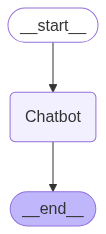

In [18]:
from IPython.display import Image

img = workflow.get_graph().draw_mermaid_png()
Image(img)


In [19]:
# 12. 대화 실행 및 결과 출력

def run_chat():
    print("=== Instagram 도움말 Tool + Tavily + LangGraph 대화 ===")
    thread_id = "user-1"
    config = {"configurable": {"thread_id": thread_id}}
    messages = []
    while True:
        user_input = input("\n질문을 입력하세요(종료: exit): ")
        if user_input.strip().lower() == "exit":
            break
        messages.append(HumanMessage(content=user_input))
        state = {"messages": messages}
        response = workflow.invoke(state, config=config)
        ai_messages = [msg for msg in response["messages"] if isinstance(msg, AIMessage)]
        if ai_messages:
            print("\n[AI 답변]:\n", ai_messages[-1].content)
        print("[현재 대화 이력]:")
        for i, m in enumerate(response["messages"]):
            role = "사용자" if m.type == "human" else "AI"
            print(f"{i+1}. [{role}] {m.content}")
        messages = response["messages"]

In [20]:
# 13. 실행
if __name__ == "__main__":
    run_chat()

=== Instagram 도움말 Tool + Tavily + LangGraph 대화 ===

[AI 답변]:
 저작권법을 준수해야 하는 이유는 다음과 같습니다:

1. **창작자의 권리 보호**  
저작권법은 창작자가 자신의 창작물에 대해 가지는 권리(저작재산권, 저작인격권 등)를 보호합니다. 이를 통해 창작자는 자신의 작품을 마음대로 이용하거나, 수익을 얻을 수 있습니다.

2. **공정한 사용과 보상**  
저작권법을 준수함으로써 창작물의 정당한 사용과 적절한 보상이 이루어집니다. 저작권을 침해하면 창작자는 경제적, 정신적으로 피해를 입게 됩니다.

3. **법적 책임 예방**  
저작권을 침해할 경우 민사상 손해배상, 형사처벌 등 법적 책임을 질 수 있습니다. 저작권법을 지키면 이러한 위험을 예방할 수 있습니다.

4. **건전한 창작 생태계 유지**  
저작권법을 준수하는 것은 창작자와 이용자 모두에게 이익이 되고, 새로운 창작 활동을 촉진하여 건전한 문화·창작 생태계를 유지하는 데 도움이 됩니다.

5. **국제적 신뢰와 거래**  
저작권법은 국제적으로도 중요한 기준입니다. 국제적 거래나 협업 시 저작권을 지키는 것은 신뢰를 높이고, 법적 분쟁을 예방할 수 있습니다.

요약하면, 저작권법을 준수하는 것은 창작자와 이용자 모두의 권리와 이익을 보호하고, 사회 전체의 문화 발전에 기여하기 때문입니다.
[현재 대화 이력]:
1. [사용자] 저작권법을 준수해야하는 이유가 뭐야?
2. [AI] 저작권법을 준수해야 하는 이유는 다음과 같습니다:

1. **창작자의 권리 보호**  
저작권법은 창작자가 자신의 창작물에 대해 가지는 권리(저작재산권, 저작인격권 등)를 보호합니다. 이를 통해 창작자는 자신의 작품을 마음대로 이용하거나, 수익을 얻을 수 있습니다.

2. **공정한 사용과 보상**  
저작권법을 준수함으로써 창작물의 정당한 사용과 적절한 보상이 이루어집니다. 저작권을 침해하면 창작자는 경제적, 정신적으로 피해를 입게 됩니다.

3. **법적 책임 예방

In [ ]:
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# 평가를 위해 vector store에서 검색한 context들과 LLM응답이 출력되도록 RAG Chain 구성
from langchain.prompts import PromptTemplate
retriever = vector_store.as_retriever()

template = """# Instruction:
당신은 정확한 정보 제공을 우선시하는 인공지능 어시스턴트입니다.
주어진 Context에 포함된 정보만 사용해서 질문에 답변하세요.
Context에 질문에 대한 명확한 정보가 있는 경우 그 내용을 바탕으로 답변하세요.
Context에 질문에 대한 명확한 정보없을 경우 "정보가 부족해서 답을 알 수 없습니다." 라고 대답합니다.
절대 Context에 없는 내용을 추측하거나 일반 상식을 이용해 답을 만들어서 대답하지 않습니다.

# Context:
{context}

# 질문:
{query}
"""
def format_docs(src_dict:dict)->str:
    """
    Vector_store에 조회한 문서들에서 내용(page_content)만 추출해서 str으로 합쳐서 반환.
    
    Args:
        src_dict(dict): {"context":list[Document],  "query":"사용자질문"}
    Returns:
        str: 각 문서의 내용을 "\n\n"으로 연결한 string
    """
    docs = src_dict["context"]
    return "\n\n".join(doc.page_content for doc in docs)

def format_docs_list(src_dict:dict)->list[str]:
    """
    Vector_store에 조회한 문서들에서 내용(page_content)만 추출해서 list로 묶어서 반환.
    
    Args:
        src_dict(dict): {"context":list[Document],  "query":"사용자질문"}
    Returns:
        list[str]: 각 문서의 내용을 담은 list
    """
    return [doc.page_content for doc in src_dict["context"]]

prompt_template = PromptTemplate(template=template)

In [ ]:
# 확인
# docs = retriever.invoke("저작권법 위반")
# docs
# format_docs({"context":docs})
# format_docs_list({"context":docs})

['저작물 이용 시 저작권 침해 점검 목록',
 '저작권자의 허락 없이 저작물을 이용할 수 있는',
 '행사할 경우 이는 공동저작물의 저작권 행사방법 위반에 해당한다.',
 '불법 사이트에 링크하는 것이 저작권 침해가 될 수']

In [ ]:
from langchain_core.runnables import RunnablePassthrough

## chain의 응답: LLM 응답, Retriever가 검색한 context들 
rag_chain = (
    RunnablePassthrough()  # dict를 LCEL로 연결.
    | {"context":retriever, "query":RunnablePassthrough()} 
    | {
        "source_context":format_docs_list, # list[Document] -> list[str]
        "llm_answer": {
                        "context":format_docs, 
                        "query": lambda x : x["query"]    # query만 추출
                    } | prompt_template | llm | StrOutputParser()
    } # 응답처리 - 입력: {"context":검색문서들, "query":"사용자질문"} 
      #          - 출력: {"source_context":검색한 문서들(list[str]), "llm_answer":LLM응답(str)}
      #             -> 응답처리 출력이 chain의 최종 출력
    
)

user_input = "저작권법을 준수해야 하는 이유가 뭐야?"
response = rag_chain.invoke(user_input)
response

{'source_context': ['저작권법으로 보호받는 권리에는 어떤 것들이 있나요?',
  '저작권, 왜 알아야 하나요    7',
  '저작권, 왜 알아야 하나요    21',
  '저작권법은 저작자의 권리와 이에 인접한 권리를 보호하고 공정한 이용을  \n도모함으로써 문화 및 관련 산업을 향상발전 시키기 위해서 필요하다.  \n저작권이나 이에 인접한 권리를 저작권법으로 보호하지 않는다면, 누구나  \n다른 사람의 저작물을 무단으로 이용하여 노력이나 비용을 들이지 않고도  \n이익을 얻음으로써, 저작자의 경제적 이익이 박탈될 수 있다. 또한 저작자의  \n의도와 다르게 저작물이 변형되고 왜곡되어 저작자의 인격적 이익이 침해될'],
 'llm_answer': 'Context에 따르면, 저작권법을 준수해야 하는 이유는 저작자의 권리와 이에 인접한 권리를 보호하고 공정한 이용을 도모함으로써 문화 및 관련 산업을 향상·발전시키기 위해서입니다. 또한 저작권법이 없다면 누구나 다른 사람의 저작물을 무단으로 이용하여 노력이나 비용을 들이지 않고도 이익을 얻을 수 있어 저작자의 경제적 이익이 박탈될 수 있고, 저작물의 변형이나 왜곡으로 저작자의 인격적 이익이 침해될 수 있기 때문입니다.'}

In [ ]:
# print(type(response), response.keys())

<class 'dict'> dict_keys(['source_context', 'llm_answer'])


In [ ]:
# llm_answer = response['llm_answer']
# print(llm_answer)

저작권법은 저작자의 권리와 이에 인접한 권리를 보호하고 공정한 이용을 도모함으로써 문화 및 관련 산업을 향상발전 시키기 위해서 필요합니다. 저작권이나 이에 인접한 권리를 저작권법으로 보호하지 않는다면, 누구나 다른 사람의 저작물을 무단으로 이용하여 노력이나 비용을 들이지 않고도 이익을 얻음으로써, 저작자의 경제적 이익이 박탈될 수 있습니다. 또한 저작자의 의도와 다르게 저작물이 변형되고 왜곡되어 저작자의 인격적 이익이 침해될 수 있습니다.


In [ ]:
# context = response["source_context"]
# context

['저작권법으로 보호받는 권리에는 어떤 것들이 있나요?',
 '저작권, 왜 알아야 하나요    7',
 '저작권, 왜 알아야 하나요    21',
 '저작권법은 저작자의 권리와 이에 인접한 권리를 보호하고 공정한 이용을  \n도모함으로써 문화 및 관련 산업을 향상발전 시키기 위해서 필요하다.  \n저작권이나 이에 인접한 권리를 저작권법으로 보호하지 않는다면, 누구나  \n다른 사람의 저작물을 무단으로 이용하여 노력이나 비용을 들이지 않고도  \n이익을 얻음으로써, 저작자의 경제적 이익이 박탈될 수 있다. 또한 저작자의  \n의도와 다르게 저작물이 변형되고 왜곡되어 저작자의 인격적 이익이 침해될']

In [ ]:
# 초기 평가
from ragas import SingleTurnSample, EvaluationDataset
from ragas.metrics import ( LLMContextRecall, 
                            LLMContextPrecisionWithReference, 
                            Faithfulness,     
                            AnswerRelevancy,  
                            )
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from dotenv import load_dotenv
load_dotenv()


# 평가데이터셋: user_input, response(정답)
user_input = "저작권법을 준수해야 하는 이유가 뭐야?"
reference = "저작권법은 누군가의 지켜져야 할 권리와 재산권에 해당하는 것이므로"

resp = rag_chain.invoke(user_input)
retrieved_context = resp['source_context']  # RAG에서 검색된 문서
response = resp['llm_answer']  # RAG의 답변


# RAGAS의 평가 데이터셋의 구성
# - user_input: 사용자 입력(질문)
# - retrieved_context: RAG에서 검색한 context(문서)들
# - response: llm의 출력(응답)
# - reference: 정답.

eval_sample1 = SingleTurnSample(  # 1개의 평가 데이터을 생성할 때 사용.
    user_input=user_input,
    retrieved_contexts=retrieved_context,
    response=response,
    reference=reference
)
# 평가용 Dataset을 생성
eval_dataset = EvaluationDataset(samples=[eval_sample1])

eval_dataset.to_pandas()

In [ ]:
# 평가 함수(객체)에 넣어줄 LLM, Embedding 모델 생성.
llm_model = ChatOpenAI(model="gpt-4.1")
e_model = OpenAIEmbeddings(model="text-embedding-3-large")

eval_model = LangchainLLMWrapper(llm_model)
eval_embedding_model = LangchainEmbeddingsWrapper(e_model)

# 평가지표 객체를 생성하고 리스트에 묶기.
metrics = [
    LLMContextRecall(llm=eval_model),
    LLMContextPrecisionWithReference(llm=eval_model),
    Faithfulness(llm=eval_model),
    AnswerRelevancy(llm=eval_model)
]

# 평가지표 객체를 이용해서 평가
eval_result = evaluate(dataset=eval_dataset, metrics=metrics)

print(type(eval_result))
eval_result.to_pandas()

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# vector_store의 데이터를 로드하여 Context 생성 및 데이터셋 생성.
# 강의 과정과 다르게 split이 된 벡터들이므로 load만 해서 context 생성하면 됨.
# 생성된 context들 중 평가에 사용할 것을 Random으로 선택해서 평가하면 됨.
from langchain_chroma import Chroma
from langchain_community.document_loaders import DirectoryLoader
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser,StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.documents import Document
from ragas import EvaluationDataset, RunConfig, evaluate
from ragas.metrics import (LLMContextRecall, 
                           Faithfulness, 
                           LLMContextPrecisionWithReference, 
                           AnswerRelevancy)
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from pydantic import BaseModel, Field
import random
import pandas as pd
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
VECTOR_DB_PATH = "vector_store/chroma/rag_chatbot"
embedding = OpenAIEmbeddings(model="text-embedding-3-large")

# chroma dircetory에서 그대로 볼러오면 되므로 지정한 collection_name과 동일하게 사용해야함. 안그러면 기존 데이터 덮어씌워지거나 초기화됨.
vector_store = Chroma(
    persist_directory=VECTOR_DB_PATH,
    embedding_function=embedding,
    collection_name="rag_chatbot" 
)

# 데이터 유무 확인
print(f"저장된 벡터 수: {vector_store._collection.count()}")

# 검색 및 평가용 context 추출
retriever = vector_store.as_retriever(search_kwargs={"k": 5})
eval_query = "유튜브 저작권 위반을 피하려면 어떻게 해야 하나요?"
eval_docs = retriever.get_relevant_documents(eval_query)

print(f"검색된 문서 수: {len(eval_docs)}")
for i, doc in enumerate(eval_docs, 1):
    print(f"[{i}] {doc.page_content[:300]}...\n")

C:\Users\HoYeon\AppData\Local\Temp\ipykernel_832\2642681082.py:27: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embedding = OpenAIEmbeddings(model="text-embedding-3-large")
C:\Users\HoYeon\AppData\Local\Temp\ipykernel_832\2642681082.py:30: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vector_store = Chroma(
C:\Users\HoYeon\AppData\Local\Temp\ipykernel_832\2642681082.py:42: LangChainDeprec

📦 저장된 벡터 수: 5616
🔍 검색된 문서 수: 5
[1] 먼저 침해금지는 권리자가 침해자에게 행위의 정지를 청구하는 것으로, 일단 더  
이상의 침해를 막으려는 것이다. 현재 ‘침해하고 있는 자’뿐만 아니라, 침해의 우려가 있는  
63)저작권법상의 제도는 아니지만, 민법상 부당이득반환청구도 가능하다(민법 제741조(부당이득의 내용)).  
법률상 원인없이 타인의 재산 또는 노무로 인하여 이익을 얻고 이로 인하여 타인에게 손해를 가한 자는 그 이익을 반환하여야 한다.); 상세한 설명은 송영식·이상정(2017), 저작권법강의, 세창, 283면 이하.  
20분짜리 영상을 만들어 게시했는데 ...

[2] 내가 다른 사람의 저작권을 침해하는 경우  
Q. 시, 소설, 동화 등 책을 읽어 주는 영상을 촬영하여 유튜브에  
게시해도 되는지?Q. 연극을 소개하고자 연극 영상을 직접 촬영하여 유튜브에  
게시하려고 하는데 저작권 문제가 될 수 있는지?Q. 영화 리뷰를 작성할 때 사용하려고 영화관에 가서 영화를  
촬영했다. 인터넷에 올리지 않더라도 저작권법상 문제가 될 수  
있는지?Q. 아이돌 안무를 따라 추는 댄스커버 영상을 올리려고 하는데  
저작권 문제가 될 수 있는지?Q. 글자체 파일이 저작권을 침해했다고 경고장을 받았다.  
글자...

[3] 62)아무나 여기에 등록할 수 있는 것은 아니고, 유튜브가 제시하는 기준에 부합하는 자만이 콘텐트  
아이디(Content ID) 사용 승인을 받을 수 있다. “YouTube는 특정 기준에 부합하는 저작권 소유자에게만 Content ID를 부여합니다. Content ID 사용 승인을 받으려면 YouTube 창작자 커뮤니티에서 자주 업로드되는 원본 자료의 상당 부분에 대해 독점권을 보유하고 있어야 합니다.” 유튜브 고객센터. https://support.google.com/youtube/answer/2797370  
수없이 많은 영상...

[4] 책이나 영화를 소개하는 채널을 운영하고 있다. 책과 영화를 구입하여 

In [ ]:
# docs 중에서 평가데이터를 생성할 때 사용할 문서 K개를 추출
#### 실제 평가 데이터셋을 생성할 때는 모든 문서를 다 사용. 
total_samples = 5

index_list = list(range(len(eval_docs)))
random.shuffle(index_list)

eval_context = []
while len(eval_context) < total_samples:
    index = index_list.pop()
    context = eval_docs[index].page_content
    if len(context) > 200:
        eval_context.append(context)
    
eval_context

['62)아무나 여기에 등록할 수 있는 것은 아니고, 유튜브가 제시하는 기준에 부합하는 자만이 콘텐트  \n아이디(Content ID) 사용 승인을 받을 수 있다. “YouTube는 특정 기준에 부합하는 저작권 소유자에게만 Content ID를 부여합니다. Content ID 사용 승인을 받으려면 YouTube 창작자 커뮤니티에서 자주 업로드되는 원본 자료의 상당 부분에 대해 독점권을 보유하고 있어야 합니다.” 유튜브 고객센터. https://support.google.com/youtube/answer/2797370  \n수없이 많은 영상물이 인터넷에 올려지고 있는 상황에서 무단 사용한  \n사례를 찾아내고 또 일일이 신고하는 것은 쉽지 않은데, 사전에 ‘플랫폼  \n사업자에게 보호를 요청할 수 있는 방법’이 있는지?O  \n대부분의 플랫폼 사업자들은 사전에 저작물 보호 요청을 할 수  \n있는 방법을 마련해두고 있다. 예컨대 네이버 저작권보호센터에  \n저작물 사전 보호 요청을 신청하면 음원, 동영상, 글자체 파일 등의 불법  \n유통을 차단해 준다. 실무에서 저작권 침해에 대한 ‘차단’은 권리자의  \n개별 신고보다는 시스템으로 이루어지는 경우가 훨씬 많다.  \n다만 등록의 절차나 어떤 기술을 적용하는지 등은 플랫폼마다 다르다. 예컨대  \n유튜브 콘텐트 아이디(Content ID)의 경우, 저작권자가 저작물을 제출하면  \n이후 올라오는 동영상은 데이터베이스와 비교하여 자동으로 검사된다. 그리고  \n차단 또는 수익 공유 등 미리 설정해 놓은 옵션에 따라 처리된다.',
 '책이나 영화를 소개하는 채널을 운영하고 있다. 책과 영화를 구입하여  \n본 뒤, 이를 ‘요약’하여 소개하는 영상을 촬영한다. 원작을 훼손하지  \n않으려고 가급적 본래의 내용 그대로 전달하고자 노력하는데, 이러한  \n경우에도 저작권자에게 허락을 받아야 하는지?O  \n공정이용 사유에 해당하지 않는 한, ‘2차적저작물작성권’ 침해가 될  \n수 있다. 도서를 요약하여 인터넷을 통해 

In [ ]:
# Context를 통해 질문, 답변 생성하는 Chain 생성.
# JsonOutputParser를 사용. -> 질문(user_input) - 정답(reference) - context(LLM이 응답 생성시 vector_store에서 참고한 검색된 문서들 )
## 스키마 생성.
### LLM으로 부터 응답받을 값들을 설계.
class EvalSchema(BaseModel):
    user_input: str = Field(..., description="사용자 질문") # 스키마 변수에 대한 설정. `...` 시작: 필수
    reference: str = Field(..., description="user_input(사용자 질문)에 대한 정답")
    qa_context: str = Field(..., description="질문, 답변 쌍을 만들때 참조한 context. 입력된 context를 수정하지 않고 그대로 넣는다.")

parser = JsonOutputParser(pydantic_object=EvalSchema)

template = """# Instruction:
당신은 RAG 평가를 위해 질문과 정답 쌍을 생성하는 인공지능 비서입니다.
다음 [Context] 에 문서가 주어지면 해당 문서를 기반으로 {num_questions}개 질문-정답 쌍을 생성하세요. 

질문과 정답을 생성한 후 Output Indicator의 format으로 출력합니다.
질문은 반드시 Context 문서에 있는 정보를 바탕으로 생성해야 합니다. Context에 없는 내용을 가지고 질문-정답을 절대 만들면 안됩니다.
올림픽에 관심있는 일반 사용자 관점의 자연스러운 질문을 작성합니다.
질문은 간결하게 작성합니다.
하나의 질문에는 한 가지씩만 내용만 작성합니다.
질문을 만들 때 "제공된 문맥에서", "문서에 설명된 대로", "주어진 문서에 따라" 또는 이와 유사한 말을 하지 마세요.
정답은 반드시 Context에 있는 정보를 바탕으로 작성합니다. 없는 내용을 추가하지 않습니다.
질문과 정답을 만들고 그 내용이 Context에 있는 항목인지 다시 한번 확인합니다.
생성된 질문-답변 쌍은 반드시 dictionary 형태로 정의하고 list로 묶어서 반환해야 합니다.
질문-답변 쌍은 반드시 {num_questions}개를 만들어야 합니다.

#Context:
{context}

Output Indicator:
{format_instructions}
"""

prompt_template = PromptTemplate(
    template=template, 
    partial_variables={"format_instructions": parser.get_format_instructions()}
)
eval_model = ChatOpenAI(model="gpt-4.1")
eval_dataset_chain = prompt_template | eval_model | parser

# 확인
eval_dataset_chain.invoke({"context":eval_context[0], "num_questions":3})

In [46]:
# context당 5개씩 질문을 생성
eval_dataset_list = []
num_questions = 5
for context in eval_context:
    eval_data = eval_dataset_chain.invoke({"context":context, "num_questions":num_questions})
    eval_dataset_list.extend(eval_data)

In [47]:
# len(eval_dataset_list)

25

In [ ]:
# eval_dataset_list[3]

{'user_input': '네이버 저작권보호센터에 사전 보호 요청을 하면 어떤 자료의 불법 유통을 차단할 수 있나요?',
 'reference': '네이버 저작권보호센터에 사전 보호 요청을 하면 음원, 동영상, 글자체 파일 등의 불법 유통을 차단할 수 있습니다.',
 'qa_context': '62)아무나 여기에 등록할 수 있는 것은 아니고, 유튜브가 제시하는 기준에 부합하는 자만이 콘텐트  아이디(Content ID) 사용 승인을 받을 수 있다. “YouTube는 특정 기준에 부합하는 저작권 소유자에게만 Content ID를 부여합니다. Content ID 사용 승인을 받으려면 YouTube 창작자 커뮤니티에서 자주 업로드되는 원본 자료의 상당 부분에 대해 독점권을 보유하고 있어야 합니다.” 유튜브 고객센터. https://support.google.com/youtube/answer/2797370  수없이 많은 영상물이 인터넷에 올려지고 있는 상황에서 무단 사용한  사례를 찾아내고 또 일일이 신고하는 것은 쉽지 않은데, 사전에 ‘플랫폼  사업자에게 보호를 요청할 수 있는 방법’이 있는지?O  대부분의 플랫폼 사업자들은 사전에 저작물 보호 요청을 할 수  있는 방법을 마련해두고 있다. 예컨대 네이버 저작권보호센터에  저작물 사전 보호 요청을 신청하면 음원, 동영상, 글자체 파일 등의 불법  유통을 차단해 준다. 실무에서 저작권 침해에 대한 ‘차단’은 권리자의  개별 신고보다는 시스템으로 이루어지는 경우가 훨씬 많다.  다만 등록의 절차나 어떤 기술을 적용하는지 등은 플랫폼마다 다르다. 예컨대  유튜브 콘텐트 아이디(Content ID)의 경우, 저작권자가 저작물을 제출하면  이후 올라오는 동영상은 데이터베이스와 비교하여 자동으로 검사된다. 그리고  차단 또는 수익 공유 등 미리 설정해 놓은 옵션에 따라 처리된다.'}

In [49]:
import pandas as pd
eval_df = pd.DataFrame(eval_dataset_list)
eval_df.head()

,user_input,reference,qa_context
0,유튜브의 Content ID는 아무나 사용할 수 있나요?,유튜브의 Content ID는 특정 기준에 부합하는 저작권 소유자만 사용할 수 있습니다.,"62)아무나 여기에 등록할 수 있는 것은 아니고, 유튜브가 제시하는 기준에 부합하는..."
1,Content ID 사용 승인을 받으려면 어떤 조건이 필요하나요?,"Content ID 사용 승인을 받으려면, 창작자 커뮤니티에서 자주 업로드되는 원본...","62)아무나 여기에 등록할 수 있는 것은 아니고, 유튜브가 제시하는 기준에 부합하는..."
2,플랫폼 사업자에게 저작물 보호를 사전에 요청할 수 있는 방법이 있나요?,대부분의 플랫폼 사업자들은 사전에 저작물 보호 요청을 할 수 있는 방법을 마련해두고...,"62)아무나 여기에 등록할 수 있는 것은 아니고, 유튜브가 제시하는 기준에 부합하는..."
3,네이버 저작권보호센터에 사전 보호 요청을 하면 어떤 자료의 불법 유통을 차단할 수 ...,"네이버 저작권보호센터에 사전 보호 요청을 하면 음원, 동영상, 글자체 파일 등의 불...","62)아무나 여기에 등록할 수 있는 것은 아니고, 유튜브가 제시하는 기준에 부합하는..."
4,유튜브에서 저작권자가 Content ID를 이용하면 영상은 어떻게 검사되나요?,"유튜브에서 저작권자가 저작물을 제출하면, 이후 올라오는 동영상은 데이터베이스와 비교...","62)아무나 여기에 등록할 수 있는 것은 아니고, 유튜브가 제시하는 기준에 부합하는..."


In [ ]:
# eval_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_input  25 non-null     object
 1   reference   25 non-null     object
 2   qa_context  25 non-null     object
dtypes: object(3)
memory usage: 732.0+ bytes


In [ ]:
#### 평가할 RAG chain(rag_chain)을 이용해서 context 문서들과 llm 응답을 받아서 
##        평가 데이터셋을 완성.
# user_input -> (rag_chain) -> {llm_answer, source_context}
context_list = []  # source_context들을 저장할 리스트
response_list = [] # llm_answer들을 저장할 리스트

for user_input in eval_df['user_input']:
    resp = rag_chain.invoke(user_input)
    context_list.append(resp['source_context'])
    response_list.append(resp['llm_answer'])

In [ ]:
# len(context_list), len(response_list)

(25, 25)

In [ ]:
# eval_df.loc[0, "user_input"]

'유튜브의 Content ID는 아무나 사용할 수 있나요?'

In [ ]:
# response_list[0]

'아니요, 유튜브의 Content ID는 아무나 사용할 수 있는 것이 아니고, 유튜브가 제시하는 기준에 부합하는 저작권 소유자에게만 부여됩니다. Content ID 사용 승인을 받으려면 유튜브 창작자 커뮤니티에서 자주 업로드되는 원본 자료의 상당 부분에 대해 독점권을 보유하고 있어야 합니다.'

In [ ]:
# context_list[0]

['62)아무나 여기에 등록할 수 있는 것은 아니고, 유튜브가 제시하는 기준에 부합하는 자만이 콘텐트  \n아이디(Content ID) 사용 승인을 받을 수 있다. “YouTube는 특정 기준에 부합하는 저작권 소유자에게만 Content ID를 부여합니다. Content ID 사용 승인을 받으려면 YouTube 창작자 커뮤니티에서 자주 업로드되는 원본 자료의 상당 부분에 대해 독점권을 보유하고 있어야 합니다.” 유튜브 고객센터. https://support.google.com/youtube/answer/2797370  \n수없이 많은 영상물이 인터넷에 올려지고 있는 상황에서 무단 사용한  \n사례를 찾아내고 또 일일이 신고하는 것은 쉽지 않은데, 사전에 ‘플랫폼  \n사업자에게 보호를 요청할 수 있는 방법’이 있는지?O  \n대부분의 플랫폼 사업자들은 사전에 저작물 보호 요청을 할 수  \n있는 방법을 마련해두고 있다. 예컨대 네이버 저작권보호센터에  \n저작물 사전 보호 요청을 신청하면 음원, 동영상, 글자체 파일 등의 불법  \n유통을 차단해 준다. 실무에서 저작권 침해에 대한 ‘차단’은 권리자의  \n개별 신고보다는 시스템으로 이루어지는 경우가 훨씬 많다.  \n다만 등록의 절차나 어떤 기술을 적용하는지 등은 플랫폼마다 다르다. 예컨대  \n유튜브 콘텐트 아이디(Content ID)의 경우, 저작권자가 저작물을 제출하면  \n이후 올라오는 동영상은 데이터베이스와 비교하여 자동으로 검사된다. 그리고  \n차단 또는 수익 공유 등 미리 설정해 놓은 옵션에 따라 처리된다.',
 '특히 유튜브 콘텐트 아이디(Content ID)를 활용하여 수익 공유를  \n조건으로 차단하지 않는 권리자들도 많다. 케이팝(K-Pop)뿐만 아니라  \n해외 곡도 다수 검색되나, 모든 곡의 저작권 정책이 게시되어 있는 것은  \n아니다. 검색이 되지 않는 음원은 별도의 이용 방안을 찾아보아야 하는',
 '유튜브 크리에이터 스튜디오의 ‘오디오 라이브러리’는 무료 음악과 음향 효과를  

In [ ]:
# eval_df["response"] = response_list
# eval_df["retrieved_contexts"] = context_list

In [ ]:
# eval_df.head()

,user_input,reference,qa_context,response,retrieved_contexts
0,유튜브의 Content ID는 아무나 사용할 수 있나요?,유튜브의 Content ID는 특정 기준에 부합하는 저작권 소유자만 사용할 수 있습니다.,"62)아무나 여기에 등록할 수 있는 것은 아니고, 유튜브가 제시하는 기준에 부합하는...","아니요, 유튜브의 Content ID는 아무나 사용할 수 있는 것이 아니고, 유튜브...","[62)아무나 여기에 등록할 수 있는 것은 아니고, 유튜브가 제시하는 기준에 부합하..."
1,Content ID 사용 승인을 받으려면 어떤 조건이 필요하나요?,"Content ID 사용 승인을 받으려면, 창작자 커뮤니티에서 자주 업로드되는 원본...","62)아무나 여기에 등록할 수 있는 것은 아니고, 유튜브가 제시하는 기준에 부합하는...",Content ID 사용 승인을 받으려면 YouTube 창작자 커뮤니티에서 자주 업...,"[62)아무나 여기에 등록할 수 있는 것은 아니고, 유튜브가 제시하는 기준에 부합하..."
2,플랫폼 사업자에게 저작물 보호를 사전에 요청할 수 있는 방법이 있나요?,대부분의 플랫폼 사업자들은 사전에 저작물 보호 요청을 할 수 있는 방법을 마련해두고...,"62)아무나 여기에 등록할 수 있는 것은 아니고, 유튜브가 제시하는 기준에 부합하는...","네, 대부분의 플랫폼 사업자들은 사전에 저작물 보호 요청을 할 수 있는 방법을 마련...",[저작권 보호를 위한 방안으로는 우선 플랫폼 사업자에게 게시 \n중단 요청을 하는...
3,네이버 저작권보호센터에 사전 보호 요청을 하면 어떤 자료의 불법 유통을 차단할 수 ...,"네이버 저작권보호센터에 사전 보호 요청을 하면 음원, 동영상, 글자체 파일 등의 불...","62)아무나 여기에 등록할 수 있는 것은 아니고, 유튜브가 제시하는 기준에 부합하는...","Context에 따르면, 네이버 저작권보호센터에 저작물 사전 보호 요청을 신청하면 ...",[네이버 서비스에서 다른 이용자가 작성한 공개 게시물이 고객님의 권리를 침해한다고 ...
4,유튜브에서 저작권자가 Content ID를 이용하면 영상은 어떻게 검사되나요?,"유튜브에서 저작권자가 저작물을 제출하면, 이후 올라오는 동영상은 데이터베이스와 비교...","62)아무나 여기에 등록할 수 있는 것은 아니고, 유튜브가 제시하는 기준에 부합하는...","저작권자가 저작물을 유튜브에 제출하면, 이후 올라오는 동영상은 데이터베이스와 비교하...","[62)아무나 여기에 등록할 수 있는 것은 아니고, 유튜브가 제시하는 기준에 부합하..."


In [ ]:
# 최종 평가

#  RAGAS 의 최종 EvaluationDataset 생성
# feature로 "user_input", "response", "retrieved_contexts", "referece"를 가진 DataFrame으로부터
#     EvaluationDataset생성

evaludation_dataset = EvaluationDataset.from_pandas(eval_df)
evaludation_dataset

eval_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1"))
eval_embedding = LangchainEmbeddingsWrapper(OpenAIEmbeddings(model="text-embedding-3-large"))
metrics = [
    LLMContextPrecisionWithReference(llm=eval_llm),
    LLMContextRecall(llm=eval_llm),
    Faithfulness(llm=eval_llm),
    AnswerRelevancy(llm=eval_llm, embeddings=eval_embedding)
]

eval_result = evaluate(dataset=evaludation_dataset, metrics=metrics)

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Exception raised in Job[12]: TimeoutError()
Exception raised in Job[18]: TimeoutError()
Exception raised in Job[22]: TimeoutError()
Exception raised in Job[26]: TimeoutError()
Exception raised in Job[29]: TimeoutError()
Exception raised in Job[30]: TimeoutError()
Exception raised in Job[34]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4.1 in organization org-tcIOufoymFleImGNXgrHAXR8 on tokens per min (TPM): Limit 30000, Used 30000, Requested 2054. Please try again in 4.108s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
Exception raised in Job[33]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4.1 in organization org-tcIOufoymFleImGNXgrHAXR8 on tokens per min (TPM): Limit 30000, Used 28990, Requested 2014. Please try again in 2.008s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 

In [60]:
eval_result.to_pandas()

,user_input,retrieved_contexts,response,reference,llm_context_precision_with_reference,context_recall,faithfulness,answer_relevancy
0,유튜브의 Content ID는 아무나 사용할 수 있나요?,"[62)아무나 여기에 등록할 수 있는 것은 아니고, 유튜브가 제시하는 기준에 부합하...","아니요, 유튜브의 Content ID는 아무나 사용할 수 있는 것이 아니고, 유튜브...",유튜브의 Content ID는 특정 기준에 부합하는 저작권 소유자만 사용할 수 있습니다.,0.916667,1.0,1.0,0.913234
1,Content ID 사용 승인을 받으려면 어떤 조건이 필요하나요?,"[62)아무나 여기에 등록할 수 있는 것은 아니고, 유튜브가 제시하는 기준에 부합하...",Content ID 사용 승인을 받으려면 YouTube 창작자 커뮤니티에서 자주 업...,"Content ID 사용 승인을 받으려면, 창작자 커뮤니티에서 자주 업로드되는 원본...",1.000000,1.0,1.0,0.982636
2,플랫폼 사업자에게 저작물 보호를 사전에 요청할 수 있는 방법이 있나요?,[저작권 보호를 위한 방안으로는 우선 플랫폼 사업자에게 게시 \n중단 요청을 하는...,"네, 대부분의 플랫폼 사업자들은 사전에 저작물 보호 요청을 할 수 있는 방법을 마련...",대부분의 플랫폼 사업자들은 사전에 저작물 보호 요청을 할 수 있는 방법을 마련해두고...,1.000000,1.0,1.0,0.950653
3,네이버 저작권보호센터에 사전 보호 요청을 하면 어떤 자료의 불법 유통을 차단할 수 ...,[네이버 서비스에서 다른 이용자가 작성한 공개 게시물이 고객님의 권리를 침해한다고 ...,"Context에 따르면, 네이버 저작권보호센터에 저작물 사전 보호 요청을 신청하면 ...","네이버 저작권보호센터에 사전 보호 요청을 하면 음원, 동영상, 글자체 파일 등의 불...",NaN,1.0,1.0,0.855429
4,유튜브에서 저작권자가 Content ID를 이용하면 영상은 어떻게 검사되나요?,"[62)아무나 여기에 등록할 수 있는 것은 아니고, 유튜브가 제시하는 기준에 부합하...","저작권자가 저작물을 유튜브에 제출하면, 이후 올라오는 동영상은 데이터베이스와 비교하...","유튜브에서 저작권자가 저작물을 제출하면, 이후 올라오는 동영상은 데이터베이스와 비교...",1.000000,1.0,NaN,0.677904
5,책이나 영화를 요약해서 소개하는 영상을 만들 때 저작권자에게 허락을 받아야 하나요?,"[책이나 영화를 소개하는 채널을 운영하고 있다. 책과 영화를 구입하여 \n본 뒤,...","공정이용 사유에 해당하지 않는 한, ‘복제권’ 또는 ‘2차적저작물작성권’ 침해가 될...","공정이용 사유에 해당하지 않는 한, ‘2차적저작물작성권’ 침해가 될 수 있습니다.",1.000000,1.0,NaN,0.699188
6,책 요약본을 인터넷에 제공한 사례에서 법원은 어떻게 판단했나요?,[서울지방법원 2003. 5. 30. 선고 2001가합64030 판결(‘여행안내서’...,책을 요약하여 인터넷으로 요약본을 제공한 ‘더 파워 오브 위(THE POWER OF...,도서를 요약하여 인터넷을 통해 요약본을 제공한 ‘더 파워 오브 위(THE POWER...,0.416667,1.0,NaN,0.664483
7,유튜브에서 몇 초까지 이용하면 저작권에 문제가 없는지 알려주나요?,"[책이나 영화를 소개하는 채널을 운영하고 있다. 책과 영화를 구입하여 \n본 뒤,...",정보가 부족해서 답을 알 수 없습니다.,"유튜브의 내부 정책일 뿐, 법적인 책임 여부를 가르는 기준이 되지 않습니다.",0.916667,NaN,NaN,0.000000
8,유튜브에서 저작권 침해 여부를 대신 판단해 주나요?,[1) 나도 권리자2) 침해당한 게 맞나: 의거 + 실질적 유사성 \n3) 침해 ...,유튜브나 아프리카TV 등이 자체적으로 실시하는 저작권 보호 정책은 저작권법에 따른 ...,"유튜브와 같은 플랫폼의 내부 정책일 뿐, 저작권 침해 여부에 대한 법적인 책임 여부...",0.916667,NaN,NaN,0.709998
9,저작권 침해 판단은 궁극적으로 누가 결정하나요?,"[마지막으로 저작권 침해에 대해 민형사상의 법적 절차를 통해 해결할 수, (2) 정...",저작권 침해 판단은 궁극적으로 법원이 결정합니다.,저작권법 제35조의3 공정이용 해당 여부도 최종적인 판단을 해야 합니다.,0.500000,0.0,1.0,0.886756
